In [6]:
# imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [7]:
# calibrate camera
objp = np.zeros((6*9,3), np.float32)
objp[:, :2] = np.mgrid[:9, :6].T.reshape(-1, 2)

objpoints = []
imgpoints = []

images = glob.glob('camera_cal/*.jpg')

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
    
ret, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
if ret:
    p = {}
    p['cmtx'] = mtx
    p['dCoefs'] = dist
    pickle.dump(p, open('camera_cal/camera_params.p', 'wb'))
        

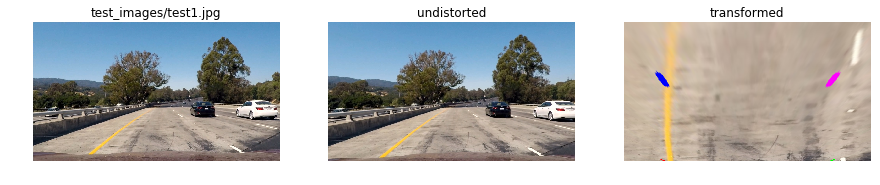

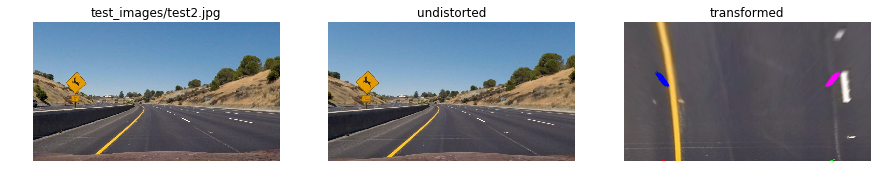

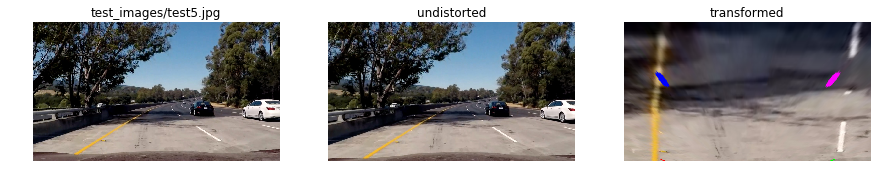

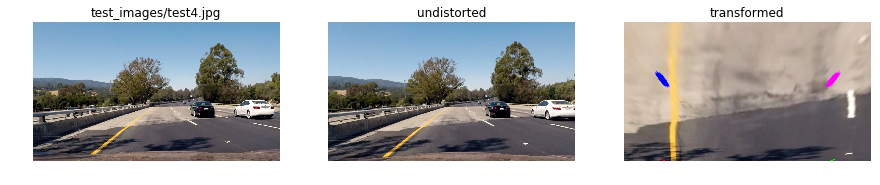

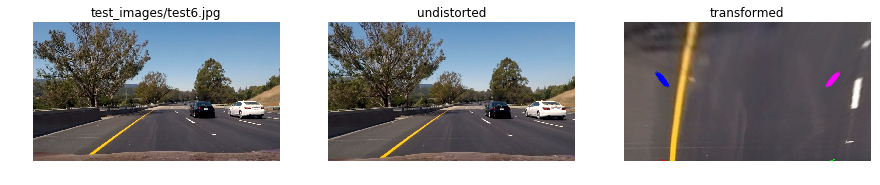

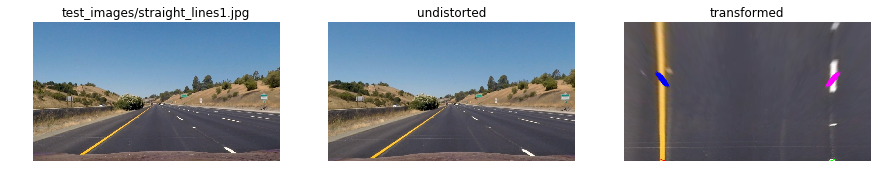

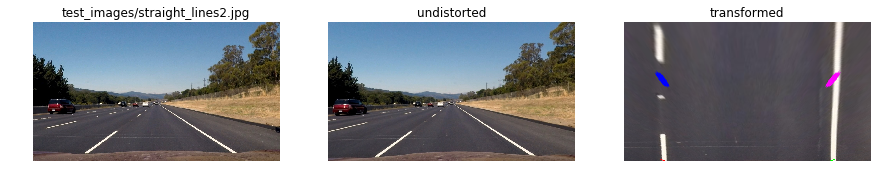

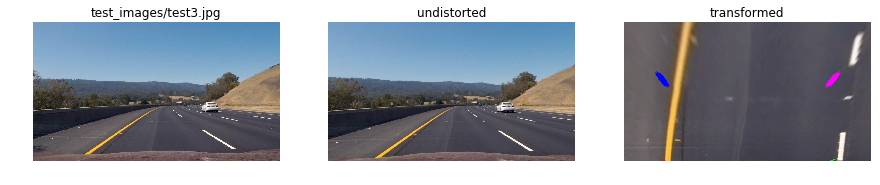

In [8]:
cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
cmtx = cam_params['cmtx']
dCoefs = cam_params['dCoefs']
for fname in glob.glob('test_images/*.jpg'):
    plt.figure(figsize=(15,30))
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')

    undistorted = cv2.undistort(img, cmtx, dCoefs, None, cmtx)
    plt.subplot(1, 3, 2)
    plt.imshow(undistorted)
    plt.title('undistorted')
    plt.axis('off')

    x,y = undistorted.shape[:2][::-1]
    src_transform_pts = np.float32([[286, 666], [1020, 666], [527, 500], [761, 500]])
    colors = [(255,0,0), (0,255,0), (0,0,255), (255,0,255)]
    for pt, col in zip(src_transform_pts, colors):
        cv2.circle(undistorted, tuple(pt), 5, col, -1)
    dst_transform_pts = np.float32([[200, y-5], [x-200, y-5], [200, 300], [x-200, 300]])
    m = cv2.getPerspectiveTransform(src_transform_pts, dst_transform_pts)
    transformed = cv2.warpPerspective(undistorted, m, (x, y))
    plt.subplot(1, 3, 3)
    plt.imshow(transformed)
    plt.title('transformed')
    plt.axis('off')
    plt.show()
    
    cam_params['x'] = x
    cam_params['y'] = y
    cam_params['src_pts'] = src_transform_pts
    cam_params['dst_pts'] = dst_transform_pts
    cam_params['transform'] = m
pickle.dump(cam_params, open('camera_cal/camera_params.p', 'wb'))
    

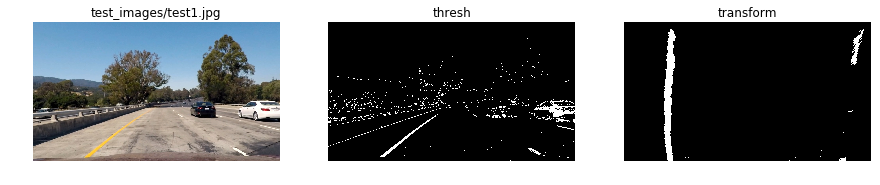

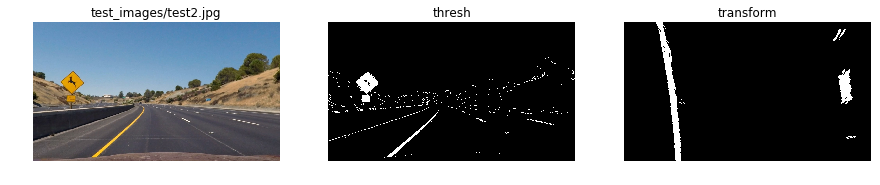

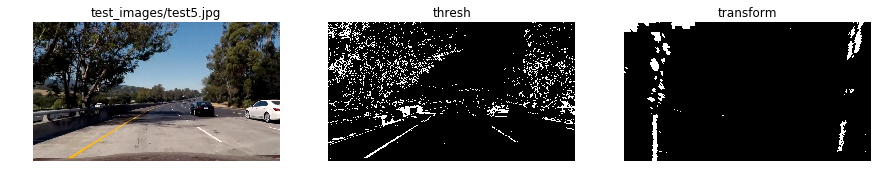

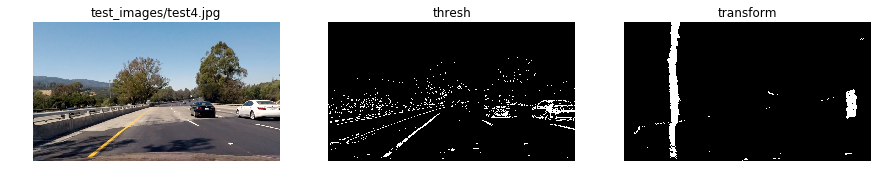

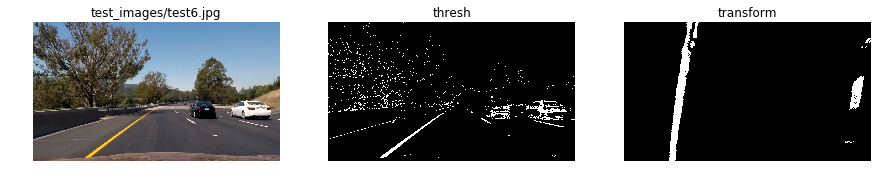

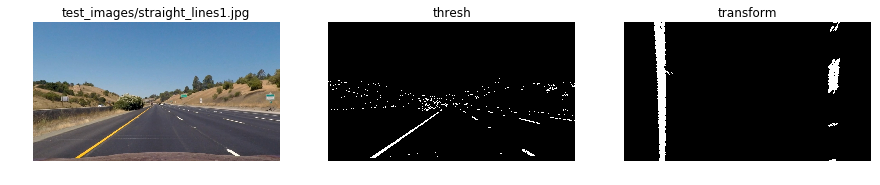

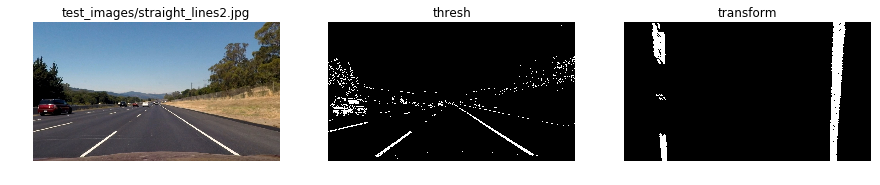

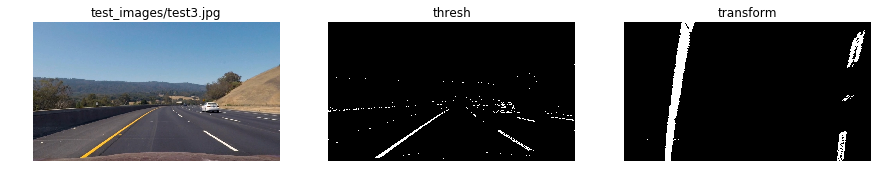

In [105]:
def s_thresh(img, thresh=(170, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_chan = hls[:,:,2]
    
    sbinary = np.zeros_like(s_chan)
    sbinary[(s_chan >= thresh[0]) & (s_chan <= thresh[1])] = 1
    
    return sbinary

def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        raise ValueError("orient should be x or y")
    
    sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255 * sobel/np.max(sobel))
    binary_out = np.zeros_like(scaled_sobel)
    binary_out[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_out

def mag_thresh(gray, sobel_kernel=3, thresh=(0, 255)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag_sobel = np.sqrt(sobel_x**2 + sobel_y**2)
    
    binary_out = np.zeros_like(mag_sobel)
    binary_out[(mag_sobel >= thresh[0]) & (mag_sobel <= thresh[1])] = 1
    return binary_out

def dir_thresh(gray, sobel_kernel=3, thresh=(0,np.pi/2)):
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    dir_sobel = np.absolute(np.arctan2(sobel_y, sobel_x))
    binary_out = np.zeros_like(dir_sobel)
    binary_out[(dir_sobel >= thresh[0]) & (dir_sobel <= thresh[1])]
    return binary_out

def threshold(rgb_img):
    gray = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    x_bin = abs_sobel_thresh(gray, thresh=(10,255))
    y_bin = abs_sobel_thresh(gray, orient='y', thresh=(60,255))
    mag_bin = mag_thresh(gray, thresh=(40,255))
    dir_bin = dir_thresh(gray, thresh=(.65,1.05))
    s_bin = s_thresh(rgb_img)
    
    combined = np.zeros_like(gray)
    combined[((x_bin == 1) & (y_bin == 1)) | ((mag_bin == 1) & (dir_bin == 1)) | (s_bin == 1)] = 1
    return combined
    
transformed = []
origs = []

cam_params = pickle.load(open('camera_cal/camera_params.p', 'rb'))
m = cam_params['transform']
cmtx = cam_params['cmtx']
dCoefs = cam_params['dCoefs']
x = cam_params['x']
y = cam_params['y']
for fname in glob.glob('test_images/*.jpg'):
    plt.figure(figsize=(15,30))
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.undistort(img, cmtx, dCoefs, None, cmtx) 
    origs.append(img)
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title(fname)
    plt.axis('off')
    
    thresh = threshold(img)
    plt.subplot(1, 3, 2)
    plt.imshow(thresh, cmap='gray')
    plt.title("thresh")
    plt.axis('off')
    
    transform = cv2.warpPerspective(thresh, m, (x, y))
    transformed.append(transform)
    plt.subplot(1, 3, 3)
    plt.imshow(transform, cmap='gray')
    plt.title("transform")
    plt.axis('off')
    plt.show
    


In [23]:

def get_lane_polynoms(bin_warped, leftlane=None, rightlane=None):
    histogram = np.sum(bin_warped, axis=0)
    
    if leftlane == None or rightlane == None:
        midpoint = np.int(histogram.shape[0]/2)
        leftlane = np.argmax(histogram[:midpoint])
        rightlane = np.argmax(histogram[midpoint:]) + midpoint
    
    nzy, nzx = np.array(bin_warped.nonzero())
    
    nwindows = 9
    margin = 100
    minpix = 50
    window_height = int(bin_warped.shape[0]/nwindows)
    
    leftlane_pts = []
    rightlane_pts = []
    
    for window in range(nwindows):
        bottom = bin_warped.shape[0] - window_height*window
        top = bottom - window_height
        leftlane_left = leftlane - margin
        leftlane_right = leftlane + margin
        rightlane_left = rightlane - margin
        rightlane_right = rightlane + margin
        
        leftlane_inds = ((nzy >= top) & (nzy <= bottom) & 
                         (nzx >= leftlane_left) & (nzx <= leftlane_right)).nonzero()[0]
        rightlane_inds = ((nzy >= top) & (nzy <= bottom) & 
                         (nzx >= rightlane_left) & (nzx <= rightlane_right)).nonzero()[0]
        
        leftlane_pts.append(leftlane_inds)
        rightlane_pts.append(rightlane_inds)
        
        if len(leftlane_inds) > minpix:
            leftlane = np.int(np.mean(nzx[leftlane_inds]))
        if len(rightlane_inds) > minpix:
            rightlane = np.int(np.mean(nzx[rightlane_inds]))
    
    leftx = nzx[np.concatenate(leftlane_pts)]
    lefty = nzy[np.concatenate(leftlane_pts)]
    rightx = nzx[np.concatenate(rightlane_pts)]
    righty = nzy[np.concatenate(rightlane_pts)]
    
    return (leftx, lefty), (rightx, righty)

In [24]:
def get_roc(polynom, y):
    A, B, _ = polynom
    return ((1 + (2*A*y+B)**2)**1.5)/(2*A)

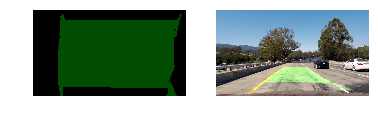

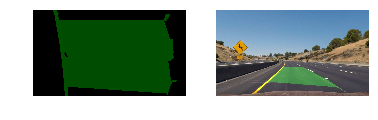

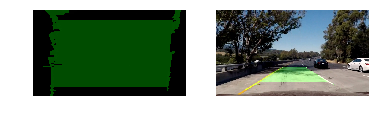

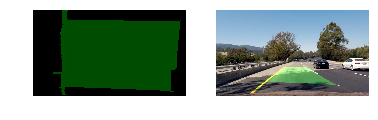

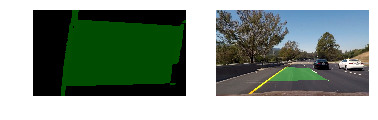

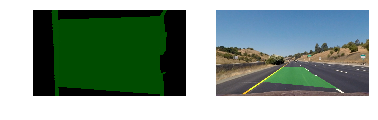

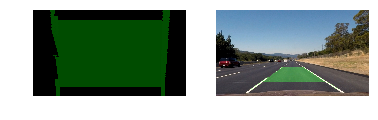

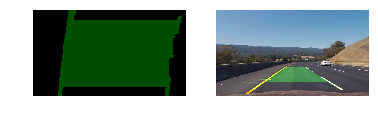

In [122]:
lane_overlays = []
src, dst = cam_params['src_pts'], cam_params['dst_pts']
minv = cv2.getPerspectiveTransform(dst, src)
for bin_warped, orig in zip(transformed, origs):
    (left_x, left_y), (right_x, right_y) = get_lane_polynoms(bin_warped)
    left_fit = np.polyfit(left_y, left_x, 2)
    right_fit = np.polyfit(right_y, right_x, 2)
    
    ploty = np.linspace(0, bin_warped.shape[0]-1, bin_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    overlay_wrp = np.zeros((bin_warped.shape[0], bin_warped.shape[1], 3), dtype=np.uint8)
    lpts = np.vstack((left_x, left_y)).T
    rpts = np.vstack((right_x, right_y)).T[::-1, :]
    pts = np.vstack((lpts, rpts))
    pts = pts.reshape(1, -1, 2)
    cv2.fillPoly(overlay_wrp, pts.astype('int32'), (0, 255, 0))
    overlay = cv2.warpPerspective(overlay_wrp, minv, orig.shape[:2][::-1], None)
    combined = cv2.addWeighted(orig, 1, overlay, .3, 0)
    combined_wrp = cv2.addWeighted(cv2.cvtColor(bin_warped, cv2.COLOR_GRAY2RGB), 
                                   1, overlay_wrp, .3, 0)
    
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(combined_wrp)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(combined)
    plt.axis('off')
    plt.show()
        